## LLaMA3 visualized

Note: requires about 40gb of RAM to run (on cpu by default)

In [1]:
"""Load .env vars"""
import os
from pathlib import Path
from dotenv import load_dotenv

load_dotenv()

# Warning: These weights are downloaded from official Meta
# sources e.g. accepting TOS and using Meta's download.sh script.
# (doesn't work with huggingface weights yet)
LLAMA_WEIGHTS_PATH = Path(os.getenv("LLAMA_WEIGHTS_PATH"))

### Load the model config

In [2]:
import json

with open(LLAMA_WEIGHTS_PATH / "params.json", "r") as f:
    model_config = json.load(f)
    print(json.dumps(model_config, indent=2))

{
  "dim": 4096,
  "n_layers": 32,
  "n_heads": 32,
  "n_kv_heads": 8,
  "vocab_size": 128256,
  "multiple_of": 1024,
  "ffn_dim_multiplier": 1.3,
  "norm_eps": 1e-05,
  "rope_theta": 500000.0
}


### Load the original model implementation w/o distributed thingies

ofc could also do this by downloading the llama3 source repo code manually but this is a bit cooler etcetc

In [3]:
import requests
import torch.distributed
import hiddenlayer as hl

meta_llama_torch_url = "https://raw.githubusercontent.com/meta-llama/llama3/32b7ddc9b638f0fd6b04b80e1845536a95f7a5d5/llama/model.py"
original_code = requests.get(meta_llama_torch_url).text

def modify_code_for_cpu(code):
# Replace parallel layers with PyTorch equivalents
    code = code.replace("ColumnParallelLinear(", "nn.Linear(")
    code = code.replace("RowParallelLinear(", "nn.Linear(")

    # Special handling for VocabParallelEmbedding
    code = code.replace(
        "VocabParallelEmbedding(",
        "nn.Embedding("
    )
    code = code.replace("init_method=lambda x: x,", "")
    code = code.replace("gather_output=False,", "")
    code = code.replace("init_method=lambda x: x", "")
    code = code.replace("input_is_parallel=True,", "")

    # Remove model parallel initialization
    code = code.replace("model_parallel_size = fs_init.get_model_parallel_world_size()", "# model_parallel_size = 1")

    # Adjust local heads calculation
    code = code.replace("self.n_local_heads = args.n_heads // model_parallel_size", "self.n_local_heads = args.n_heads")
    code = code.replace("self.n_local_kv_heads = self.n_kv_heads // model_parallel_size", "self.n_local_kv_heads = self.n_kv_heads")

    # Remove CUDA-specific code
    code = code.replace(".cuda()", "")

    # Add import for torch.nn
    code = "import torch.nn as nn\n" + code

    return code

# Modify the code
modified_code = modify_code_for_cpu(original_code)
exec(modified_code)

original_llama_model = Transformer(ModelArgs(max_seq_len=2048, max_batch_size=32, **model_config)).bfloat16().to("cpu")

### torchinfo.summary

In [4]:
from torchinfo import summary

tokens = [128000, 791, 5015, 574, 9960, 304, 264, 39139, 315, 4251, 11, 779, 433, 2011, 617, 1027]

llama_summary = summary(original_llama_model, input_data=[torch.tensor(tokens).unsqueeze(0), 0], device="cpu")
print(llama_summary)

Layer (type:depth-idx)                   Output Shape              Param #
Transformer                              [1, 16, 128256]           --
├─Embedding: 1-1                         [1, 16, 4096]             525,336,576
├─ModuleList: 1-2                        --                        --
│    └─TransformerBlock: 2-1             [1, 16, 4096]             --
│    │    └─RMSNorm: 3-1                 [1, 16, 4096]             4,096
│    │    └─Attention: 3-2               [1, 16, 4096]             41,943,040
│    │    └─RMSNorm: 3-3                 [1, 16, 4096]             4,096
│    │    └─FeedForward: 3-4             [1, 16, 4096]             176,160,768
│    └─TransformerBlock: 2-2             [1, 16, 4096]             --
│    │    └─RMSNorm: 3-5                 [1, 16, 4096]             4,096
│    │    └─Attention: 3-6               [1, 16, 4096]             41,943,040
│    │    └─RMSNorm: 3-7                 [1, 16, 4096]             4,096
│    │    └─FeedForward: 3-8           

### torchview graph

Note: requires `graphviz` on the system ([https://stackoverflow.com/a/42875446/4249857](https://stackoverflow.com/a/42875446/4249857))

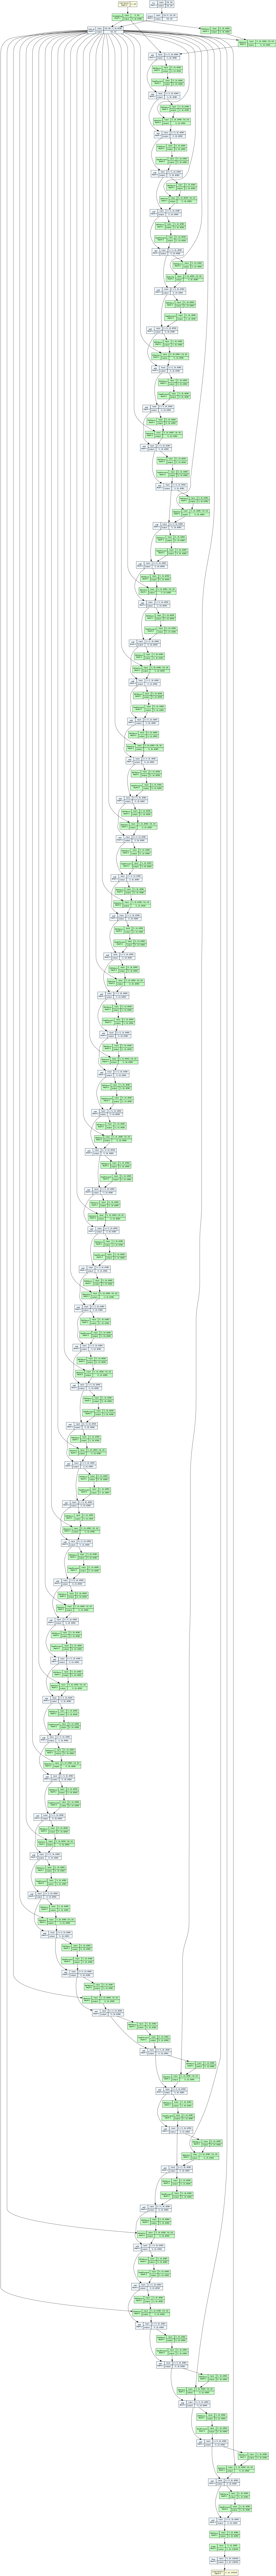

In [5]:
from torchview import draw_graph
import graphviz

graphviz.set_jupyter_format("png")
model_graph = draw_graph(original_llama_model, input_data=[torch.tensor(tokens).unsqueeze(0), 0], device="cpu", depth=2)
model_graph.visual_graph